# Implementing a Multi-View VAE for MNIST-SHVN

### AUTHORS: ALBERTO CASTELLANO MACIAS (100414242) &
### MOHAMED AFIF CHIFAOUI (100452024)


## Dataset

In [ ]:
import torch
from torch import nn
import numpy as np
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch import optim
import time

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
# Set default device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def get_dataset(batch_size,  dataset_directory = './data'):

    mnist_transformation = transforms.Compose([
        transforms.ToTensor(),
    ])

    svhn_transformation = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    #MNIST:
    train_dataset = torchvision.datasets.MNIST(dataset_directory, download = True, transform = mnist_transformation)

    # Use sampler for randomization
    training_sampler = torch.utils.data.SubsetRandomSampler(range(len(train_dataset)))

    # Prepare Data Loaders for training and validation
    mnist_trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=training_sampler)

    #SVHN:

    train_dataset = torchvision.datasets.SVHN(dataset_directory, download = True, transform = svhn_transformation)

    # Use sampler for randomization
    training_sampler = torch.utils.data.SubsetRandomSampler(range(len(train_dataset)))

    # Prepare Data Loaders for training and validation
    svhn_trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=training_sampler)


    return mnist_trainloader, svhn_trainloader

In [ ]:
mnist_trainloader, svhn_trainloader = get_dataset(32)

100%|██████████| 9912422/9912422 [00:00<00:00, 92444703.66it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 117039317.70it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29646819.20it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22126049.67it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 182040794/182040794 [00:19<00:00, 9291450.15it/s] 


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize to pot
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

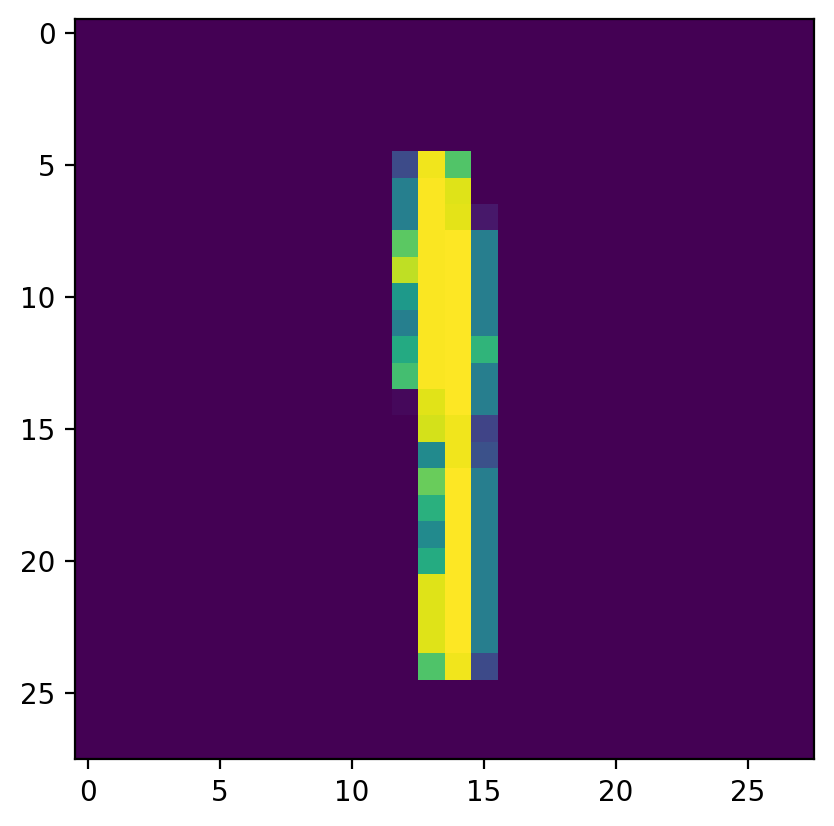

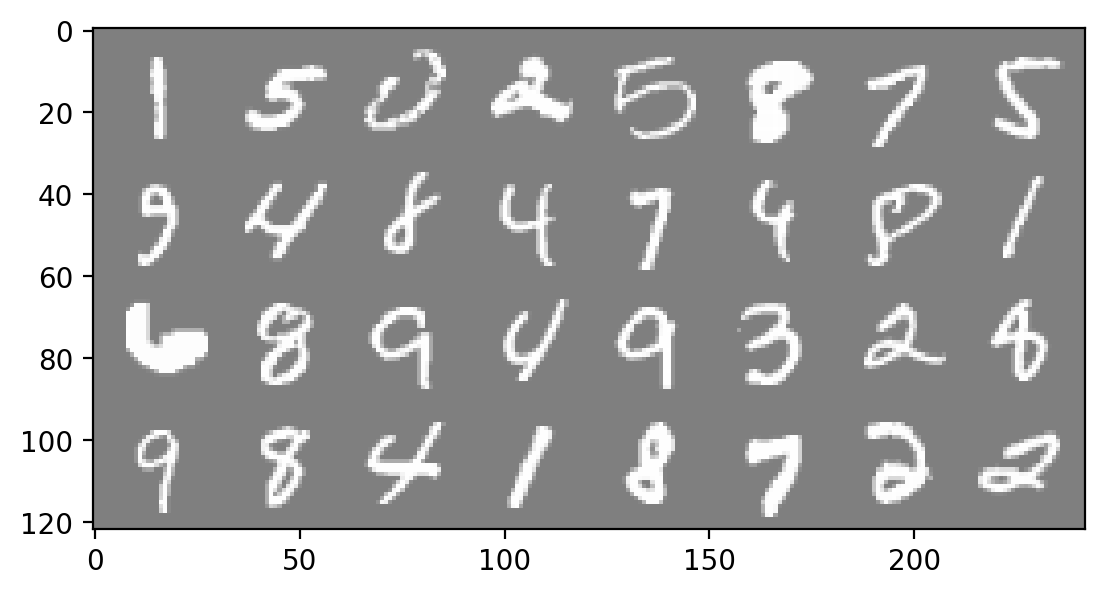

In [ ]:
mnist_train = iter(mnist_trainloader)

i,l = next(mnist_train)

imshow(i[0,:,:,:])

imshow(torchvision.utils.make_grid(i))

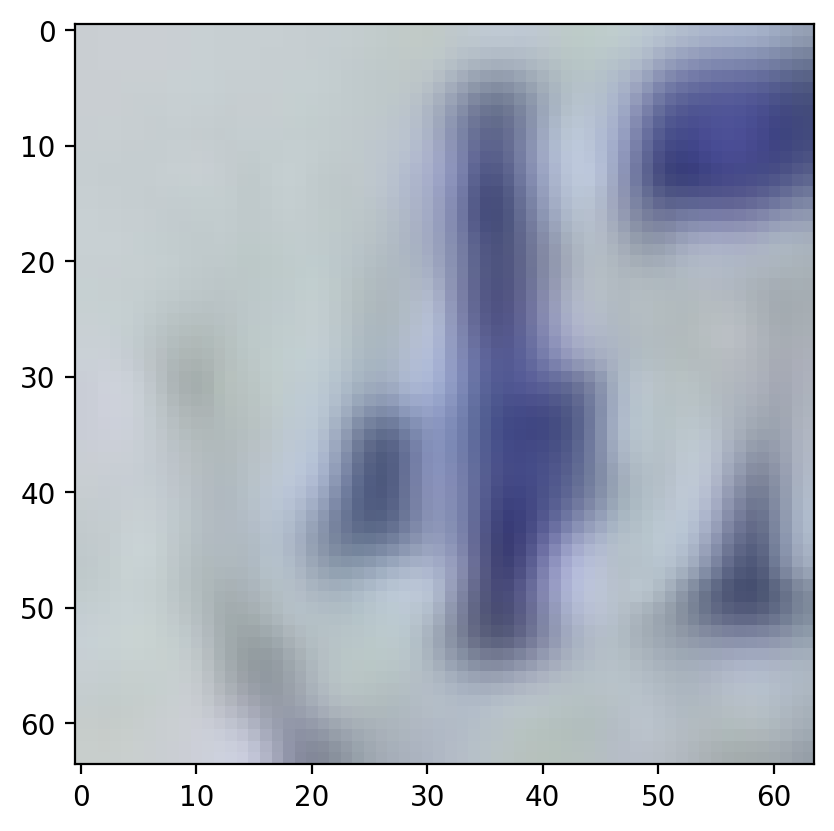

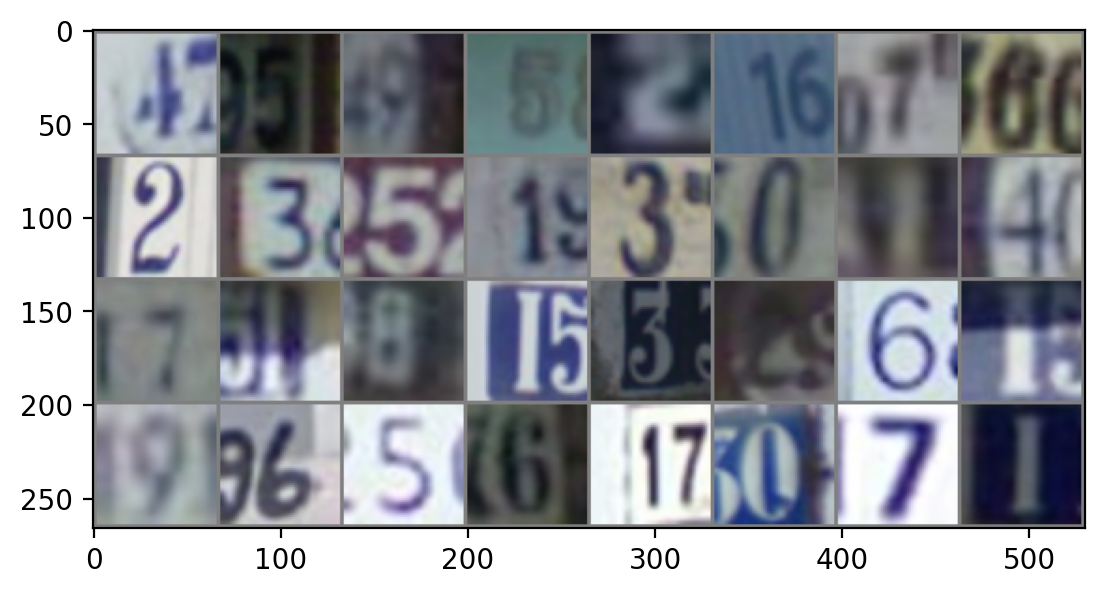

In [ ]:
svhm_train = iter(svhn_trainloader)

i,l = next(svhm_train)

imshow(i[0,:,:,:])

imshow(torchvision.utils.make_grid(i))

## Encoder-Decoder

### MNIST

In [ ]:
class MNIST_encoder(nn.Module):
    '''This class corresponds to MNIST encoder. It receives as imput the dimension of the latent space.
    In this case, the number of entering channels is only one because MNIST dataset is composed of gray-scale images'''

    def __init__(self,dimz,channels=1,var_x=0.1):

        super().__init__()

        self.dimz = dimz    #dimz is k, the dimension of the latent space

        # Output Size Formula: [(W−K+2P)/S]+1
        #W = Width/Length of the image
        #K = Filter Kernel Size
        #P = Padding(Extra-Pixels in borders, normally 0s)
        #S = Stride(Steps the Kernel moves)

        #Input dim: [32, 1, 28, 28]
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=14,
                               kernel_size=4, stride=2, padding=1)

        #Output dim: [32, 14, 14, 14]
        self.conv2 = nn.Conv2d(in_channels=14, out_channels=28,
                               kernel_size=4, stride=2, padding=2)

        #Output dim: [32, 28, 8, 8]
        self.conv3 = nn.Conv2d(in_channels=28, out_channels=56,
                               kernel_size=4, stride=2, padding=1)

        #Output dim: [32, 56, 4, 4]
        self.conv4 = nn.Conv2d(in_channels=56, out_channels=112,
                               kernel_size=4, stride=1, padding=0)

        #Output dim: [32, 112, 1, 1]

        # self.linear is a linear layer with dimz*2 outputs
        self.linear = nn.Linear(112,dimz*2)

        self.relu = nn.ReLU()

        self.softplus = nn.Softplus()

    def forward(self,x):

        # The forward method to project and image into a 2dimz dimensional vector

        z = self.relu(self.conv1(x))
        z = self.relu(self.conv2(z))
        z = self.relu(self.conv3(z))
        z = self.relu(self.conv4(z))

        # Transform z into a 256-dim vector
        z = z.view(-1,112)
        z = self.linear(z)

        return z

    def encode_and_sample(self,x,flag_sample=True):
        '''This methods compute both the posterior mean and variance.
        Furthermore, it returns a sample generated from MNIST data using reparameterization trick'''

        # We obtain the encoder projection using the forward method

        z = self.forward(x)

        # The mean is the first dimz components of the forward output

        mu = z[:, :self.dimz]

        # We compute the variance from the last dimz components using a
        # soft plus
        var = self.softplus(0.5 * z[:, self.dimz:])

        sample = None

        if(flag_sample==True):

            eps = torch.randn_like(var)

            sample = mu + eps*(var**0.5)

        return mu,var,sample

In [ ]:
mnist_enc = MNIST_encoder(dimz=10) #10 numbers (0 to 9)

i,l = next(mnist_train)

mu_z,var_z,sample = mnist_enc.encode_and_sample(i)

print(mu_z[0,:])
print(var_z[0,:])

tensor([-0.0569, -0.0839, -0.0300, -0.0066,  0.0323, -0.0544, -0.0796, -0.0486,
        -0.1062,  0.0885], grad_fn=<SliceBackward0>)
tensor([0.7013, 0.7119, 0.6792, 0.7054, 0.6711, 0.7048, 0.6918, 0.6696, 0.7095,
        0.6926], grad_fn=<SliceBackward0>)


In [ ]:
class MNIST_decoder(nn.Module):

    def __init__(self,dimz,channels=1,var_x=0.1):

        super().__init__()

        # We expand z into a 112 dimensional vector

        self.linear = nn.Linear(dimz,112)

        self.tconv1 = nn.ConvTranspose2d(112, 56, kernel_size=4, stride=1,padding=0)
        self.tconv2 = nn.ConvTranspose2d(56, 28, kernel_size=4, stride=2,padding=1)
        self.tconv3 = nn.ConvTranspose2d(28, 14, kernel_size=4, stride=2,padding=2)
        self.tconv4 = nn.ConvTranspose2d(14, channels, kernel_size=4, stride=2,padding=1)

        self.relu = nn.ReLU()

        self.tanh = nn.Tanh()

    def forward(self,z):

        x = self.relu(self.linear(z).view(-1,112,1,1))
        x = self.relu(self.tconv1(x))
        x = self.relu(self.tconv2(x))
        x = self.relu(self.tconv3(x))
        x = self.relu(self.tconv4(x))
        return x

    def decode(self,z):

        # This function simply calls the forward method

        return self.forward(z)

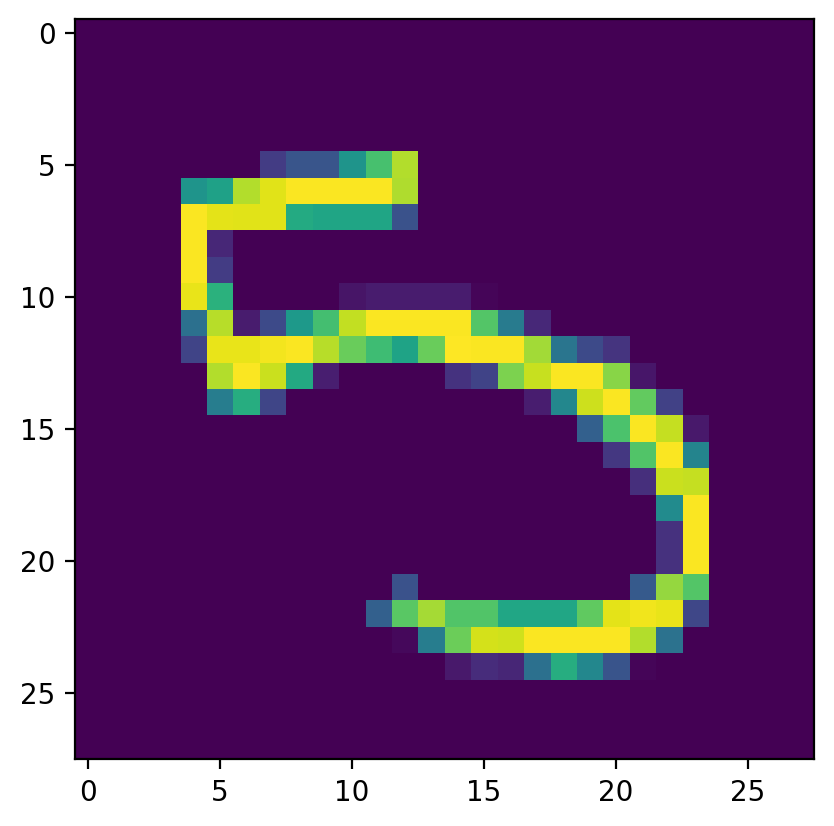

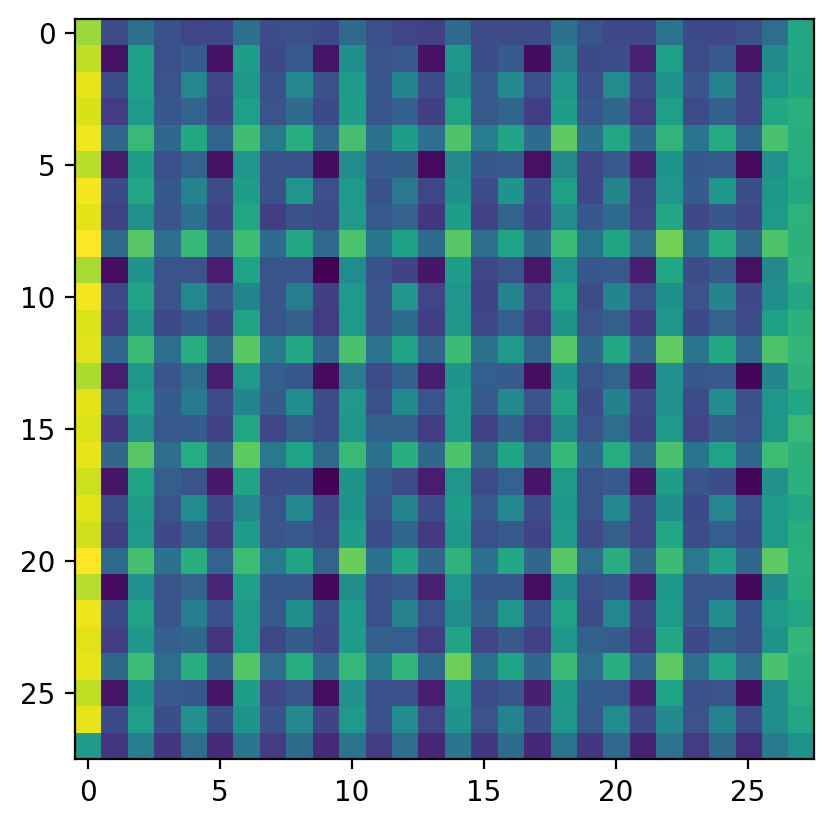

In [ ]:
mnist_dec = MNIST_decoder(dimz=10)

i,l = next(mnist_train)

mu_z,var_z,sample = mnist_enc.encode_and_sample(i)

x_mean = mnist_dec.decode(mu_z).detach()

imshow(i[0,:,:,:])

imshow(x_mean[0,:,:,:])

### SVHN

In [ ]:
class SVHM_encoder(nn.Module):
    '''This class corresponds to SVHM encoder. It receives as imput the dimension of the latent space.
    In this case, the number of entering channels is only one because SVHM dataset is composed of gray-scale images'''

    def __init__(self,dimz,channels=3,var_x=0.1):

        super().__init__()

        self.dimz = dimz    #dimz is k, the dimension of the latent space

        # Output Size Formula: [(W−K+2P)/S]+1
        #W = Width/Length of the image
        #K = Filter Kernel Size
        #P = Padding(Extra-Pixels in borders, normally 0s)
        #S = Stride(Steps the Kernel moves)

        #Input dim: [32, 3, 64, 64]
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=32,
                               kernel_size=4, stride=2, padding=1)

        #Output dim: [32, 32, 32, 32]
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32,
                               kernel_size=4, stride=2, padding=1)

        #Output dim: [32, 32, 16, 16]
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64,
                               kernel_size=4, stride=2, padding=1)

        #Output dim: [32, 64, 8, 8]
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64,
                               kernel_size=4, stride=2, padding=1)

        #Output dim: [32, 64, 4, 4]
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=256,
                               kernel_size=4, stride=1, padding=0)

        #Output dim: [32, 256, 1, 1]

        # self.linear is a linear layer with dimz*2 outputs
        self.linear = nn.Linear(256,dimz*2)

        self.relu = nn.ReLU()

        self.softplus = nn.Softplus()

    def forward(self,x):
        '''The forward method to project and image into a 2dimz dimensional vector'''

        z = self.relu(self.conv1(x))
        z = self.relu(self.conv2(z))
        z = self.relu(self.conv3(z))
        z = self.relu(self.conv4(z))
        z = self.relu(self.conv5(z))

        # Transform z into a 256-dim vector
        z = z.view(-1,256)
        z = self.linear(z)

        return z

    def encode_and_sample(self,x,flag_sample=True):
        '''This methods compute both the posterior mean and variance.
        Furthermore, it returns a sample generated from SVHM data using reparameterization trick'''

        # We obtain the encoder projection using the forward method

        z = self.forward(x)

        # The mean is the first dimz components of the forward output

        mu = z[:, :self.dimz]

        # We compute the variance from the last dimz components using a
        # soft plus
        var = self.softplus(0.5 * z[:, self.dimz:])

        sample = None

        if(flag_sample==True):

            eps = torch.randn_like(var)

            sample = mu + eps*(var**0.5)

        return mu,var,sample

In [ ]:
svhm_enc = SVHM_encoder(dimz=10) #10 numbers (0 to 9)

i,l = next(svhm_train)

mu_z,var_z,sample = svhm_enc.encode_and_sample(i)

print(mu_z[0,:])
print(var_z[0,:])

tensor([ 0.0011, -0.0068, -0.0165, -0.0349, -0.0632, -0.0335, -0.0460,  0.0105,
        -0.0468, -0.0598], grad_fn=<SliceBackward0>)
tensor([0.6998, 0.6796, 0.6775, 0.6865, 0.7029, 0.6918, 0.6843, 0.6888, 0.6963,
        0.7018], grad_fn=<SliceBackward0>)


In [ ]:
class SVHM_decoder(nn.Module):

    def __init__(self,dimz,channels=3,var_x=0.1):

        super().__init__()

        # We expand z into a 256 dimensional vector

        self.linear = nn.Linear(dimz,256)

        self.relu = nn.ReLU()

        self.tanh = nn.Tanh()

        # self.tconv1 is a convolutional layer, with 64 output channels, kernel size 4, stride 1,
        # and padding 0

        self.tconv1 = nn.ConvTranspose2d(256, 64, kernel_size=4, stride=1,padding=0)

        # self.tconv2 is a convolutional layer, with 64 output channels, kernel size 4, stride 2,
        # and padding 1

        self.tconv2 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2,padding=1)

        # self.tconv3 is a convolutional layer, with 32 output channels, kernel size 4, stride 2,
        # and padding 1

        self.tconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2,padding=1)

        # self.tconv3 is a convolutional layer, with 32 output channels, kernel size 4, stride 2,
        # and padding 1

        self.tconv4 = nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2,padding=1)

        # self.tconv3 is a convolutional layer, with channels output channels, kernel size 4, stride 2,
        # and padding 1

        self.tconv5 = nn.ConvTranspose2d(32, channels, kernel_size=4, stride=2,padding=1)

    def forward(self,z):

        x = self.relu(self.linear(z).view(-1,256,1,1))
        x = self.relu(self.tconv1(x))
        x = self.relu(self.tconv2(x))
        x = self.relu(self.tconv3(x))
        x = self.relu(self.tconv4(x))
        x = self.tanh(self.tconv5(x))
        return x

    def decode(self,z):

        # This function simply calls the forward method

        return self.forward(z)

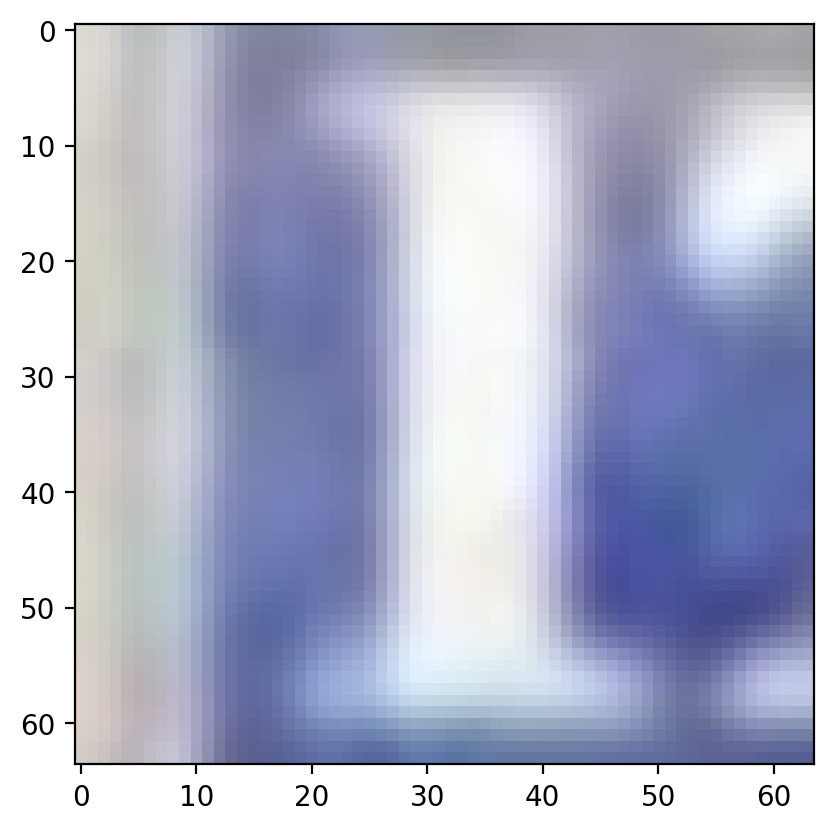

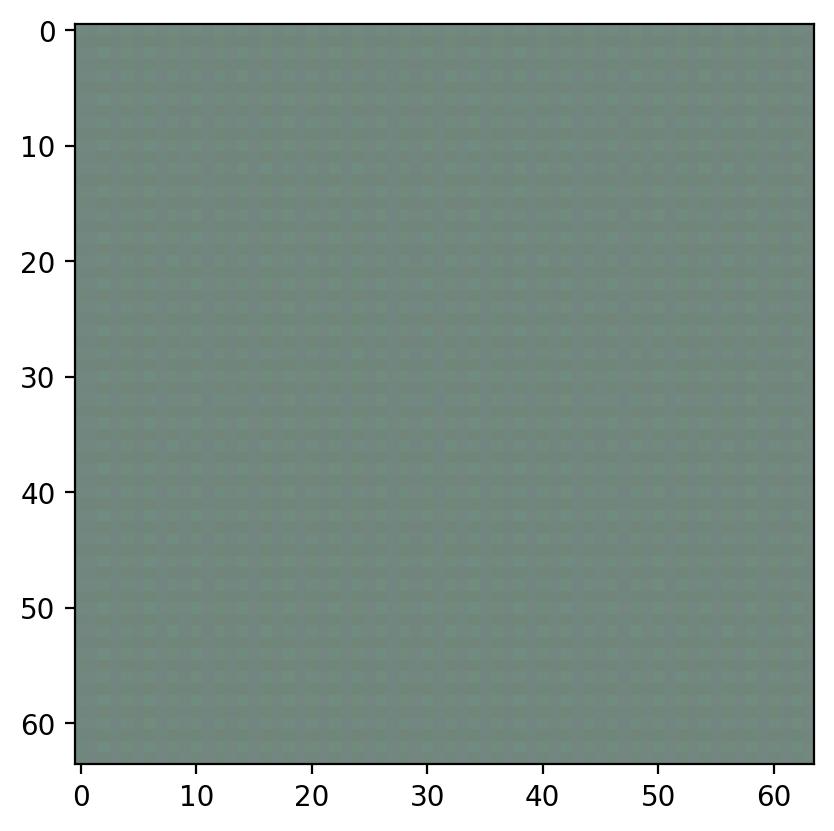

In [ ]:
svhm_dec = SVHM_decoder(dimz=10)

i,l = next(svhm_train)

mu_z,var_z,sample = svhm_enc.encode_and_sample(i)

x_mean = svhm_dec.decode(mu_z).detach()

imshow(i[0,:,:,:])

imshow(x_mean[0,:,:,:])

## Loss Function

In [ ]:
def eval_Gaussian_LL(x,mu_x,var_x):

    # x is a mini-batch of images.

    # mu_x is a mini-batch of reconstructed images.

    # var_x is a torch constant

    D = x.shape[1] * x.shape[2] * x.shape[3]   # Dimension of the image

    x = x.reshape(-1, D)

    mu_x = mu_x.reshape(-1, D)

    var_x = torch.ones_like(mu_x) * var_x

    # Constant term in the gaussian distribution
    cnt = D * np.log(2 * np.pi) + torch.sum(torch.log(var_x), dim=-1)

    # log-likelihood per datapoint

    logp_data = -0.5 * (cnt + torch.sum((x - mu_x) * var_x ** -1 * (x - mu_x), dim=-1))

    # Accumulated Gaussian log-likelihood for all datapoints in the batch
    logp = torch.sum(logp_data)

    return logp,logp_data

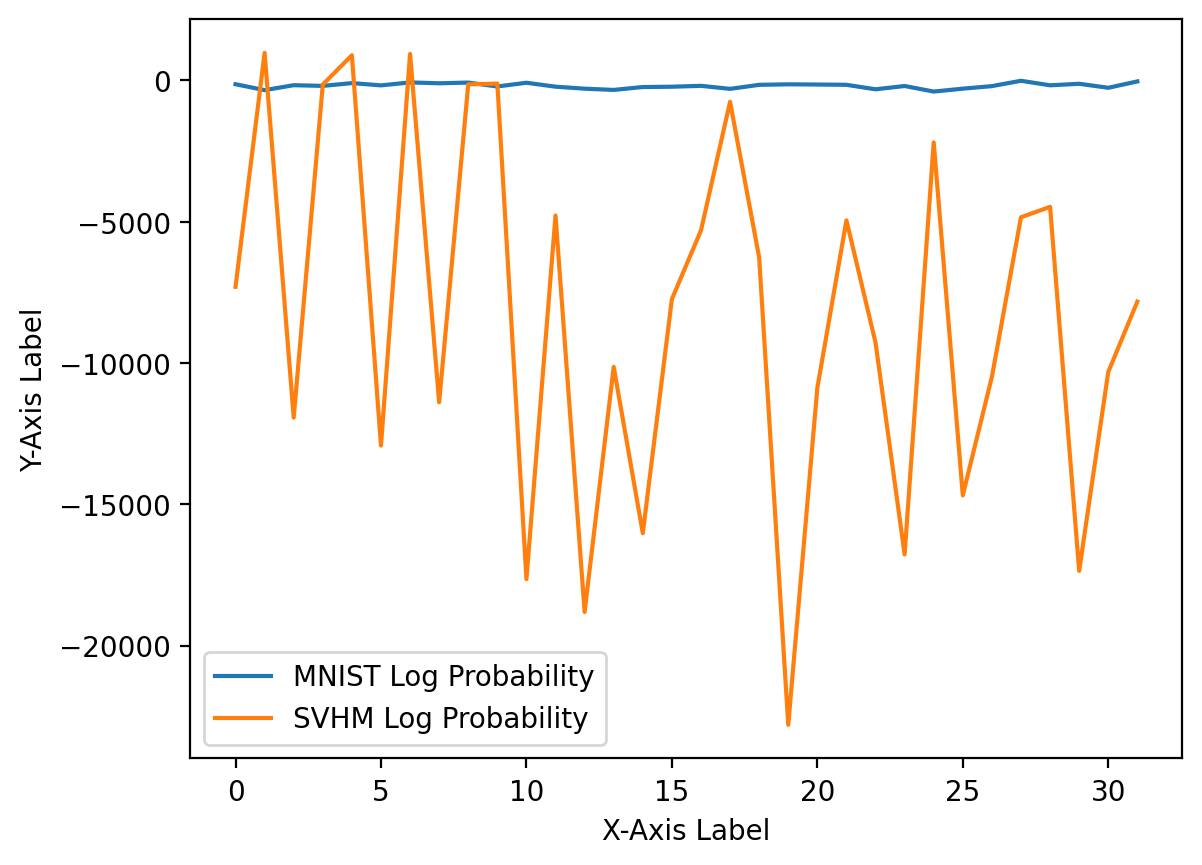

In [ ]:
var_x = 0.1


MNIST_i,l = next(mnist_train)
SVHM_i,l = next(svhm_train)

MNIST_mu_z,MNIST_var_z,MNIST_sample = mnist_enc.encode_and_sample(MNIST_i)
SVHM_mu_z,SVHM_var_z,SVHM_sample = svhm_enc.encode_and_sample(SVHM_i)

#Product of Experts (PoD)
mu_z = 0.5*MNIST_mu_z + 0.5*SVHM_mu_z
var_z = 0.5*MNIST_var_z + 0.5*SVHM_var_z

MNIST_x_mean = mnist_dec.decode(mu_z).detach()
SVHM_x_mean = svhm_dec.decode(mu_z).detach()

# print(mu_z.size())
# print(var_z.size())


MNIST_logp,MNIST_logp_data = eval_Gaussian_LL(x=MNIST_i,mu_x=MNIST_x_mean,var_x=var_x)
SVHM_logp,SVHM_logp_data = eval_Gaussian_LL(x=SVHM_i,mu_x=SVHM_x_mean,var_x=var_x)

# Create the plot for MNIST_logp_data and add a label
plt.plot(np.arange(0, 32), MNIST_logp_data, label='MNIST Log Probability')

# Create the plot for SVHM_logp_data and add a label
plt.plot(np.arange(0, 32), SVHM_logp_data, label='SVHM Log Probability')

# Add labels to the x-axis and y-axis
plt.xlabel('X-Axis Label')
plt.ylabel('Y-Axis Label')

# Add a legend to the plot to distinguish between the two lines
plt.legend()

# Show the plot
plt.show()

## Multiview

In [ ]:
class MultiviewVAE(nn.Module):
    def __init__(self, dimz, var_x=0.1):
        super().__init__()

        self.w_param = nn.Parameter(torch.Tensor([0.5]))

        self.dimz = dimz
        self.var_x = var_x
        self.MNIST_channels = 1

        #ORIGINAL
        self.SVHM_channels = 3

        # Create instances of MNIST and SVHN encoders and decoders
        self.mnist_enc = MNIST_encoder(dimz,self.MNIST_channels,self.var_x)
        self.mnist_dec = MNIST_decoder(dimz,self.MNIST_channels,self.var_x)

        self.svhm_enc = SVHM_encoder(dimz,self.SVHM_channels,self.var_x)
        self.svhm_dec = SVHM_decoder(dimz,self.SVHM_channels,self.var_x)



        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)


    def forward(self, mnist_x, svhm_x):
        # Encode images from both datasets
        mnist_mu_z, mnist_var_z, _ = self.mnist_enc.encode_and_sample(mnist_x)
        svhm_mu_z, svhm_var_z, _ = self.svhm_enc.encode_and_sample(svhm_x)

        self.w = torch.sigmoid(self.w_param)
        # print(f'W: {self.w}')


        # Combine latent representations with a product of experts approach
        mu_z = self.w * mnist_mu_z + (1-self.w) * svhm_mu_z
        var_z = self.w * mnist_var_z + (1-self.w) * svhm_var_z


        #Sample from posterior
        eps = torch.randn_like(var_z)
        sample_z = mu_z + eps*(var_z**0.5)

        # Reconstruct images using the combined latent representation
        mnist_x_mean = self.mnist_dec.decode(sample_z)
        svhm_x_mean = self.svhm_dec.decode(sample_z)

        return mnist_x_mean, svhm_x_mean, mu_z, var_z

    def calculate_loss(self, mnist_x, svhm_x):
        # Forward pass
        mnist_x_mean, svhm_x_mean, mu_z, var_z = self.forward(mnist_x, svhm_x)

        # Reconstruction loss
        mnist_logp, _ = eval_Gaussian_LL(x=mnist_x, mu_x=mnist_x_mean, var_x=self.var_x)
        svhm_logp, _ = eval_Gaussian_LL(x=svhm_x, mu_x=svhm_x_mean, var_x=self.var_x)

        # KL divergence loss
        kl_divergence = 0.5 * torch.sum(var_z + mu_z**2 - 1 - torch.log(var_z), dim=1)

        # Total loss
        total_loss = -(mnist_logp + svhm_logp - kl_divergence).mean()

        return total_loss

    def sample(self,num_imgs):

      with torch.no_grad():

        eps = torch.randn([num_imgs,self.dimz]).to(self.device)

        x_mnist = self.mnist_dec.decode(eps)
        x_svhm = self.svhm_dec.decode(eps)

        return x_mnist.to("cpu").detach(), x_svhm.to("cpu").detach()

In [ ]:
# Choose the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the MultiviewVAE and move it to the selected device
multiview_vae = MultiviewVAE(dimz=20)

# Set up optimizer
optimizer = torch.optim.Adam(multiview_vae.parameters(), lr=0.001)

# Number of training epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    for mnist_data, svhm_data in zip(mnist_trainloader, svhn_trainloader):
        # Transfer data to device if using GPU
        mnist_data = mnist_data[0].to(device)
        svhm_data = svhm_data[0].to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Calculate loss and backpropagate
        loss = multiview_vae.calculate_loss(mnist_data, svhm_data)
        loss.backward()

        # Update the weights
        optimizer.step()

    # Print the loss at the end of each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')


Epoch [1/10], Loss: -43714.6328125
Epoch [2/10], Loss: -57540.8125
Epoch [3/10], Loss: -52739.46875
Epoch [4/10], Loss: -53423.9375
Epoch [5/10], Loss: -51132.09375
Epoch [6/10], Loss: -56775.8203125
Epoch [7/10], Loss: -61157.29296875
Epoch [8/10], Loss: -57245.44921875
Epoch [9/10], Loss: -67859.671875
Epoch [10/10], Loss: -64081.734375


### Random Images Generation

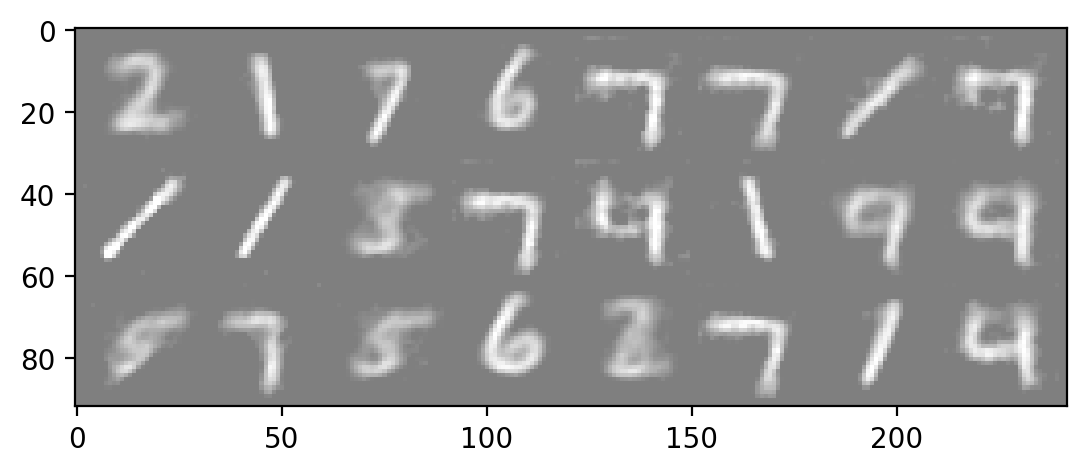

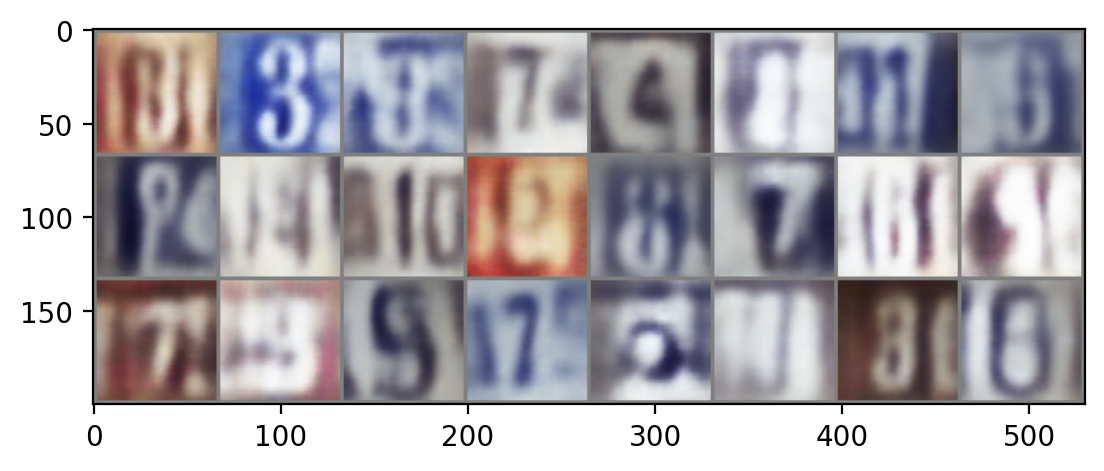

In [ ]:
x_mnist, x_svhm = multiview_vae.sample(24)

imshow(torchvision.utils.make_grid(x_mnist))
imshow(torchvision.utils.make_grid(x_svhm))

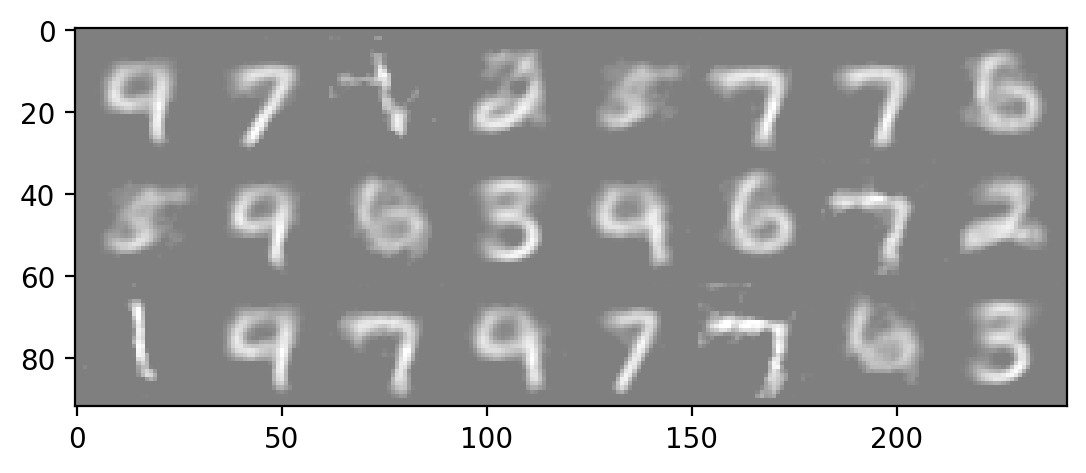

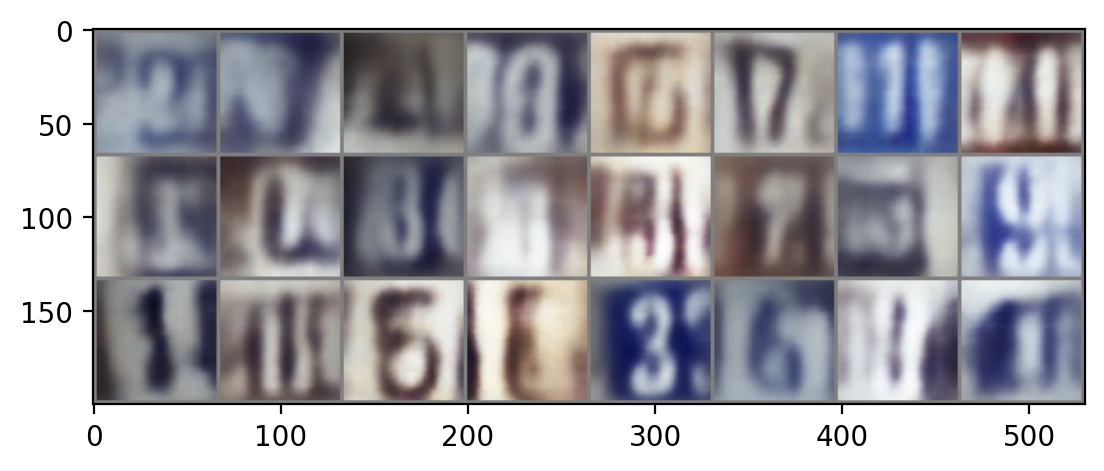

In [ ]:
x_mnist, x_svhm = multiview_vae.sample(24)

imshow(torchvision.utils.make_grid(x_mnist))
imshow(torchvision.utils.make_grid(x_svhm))

### Reconstruction

100%|██████████| 64275384/64275384 [00:03<00:00, 19093985.40it/s]


Original MNIST Images:


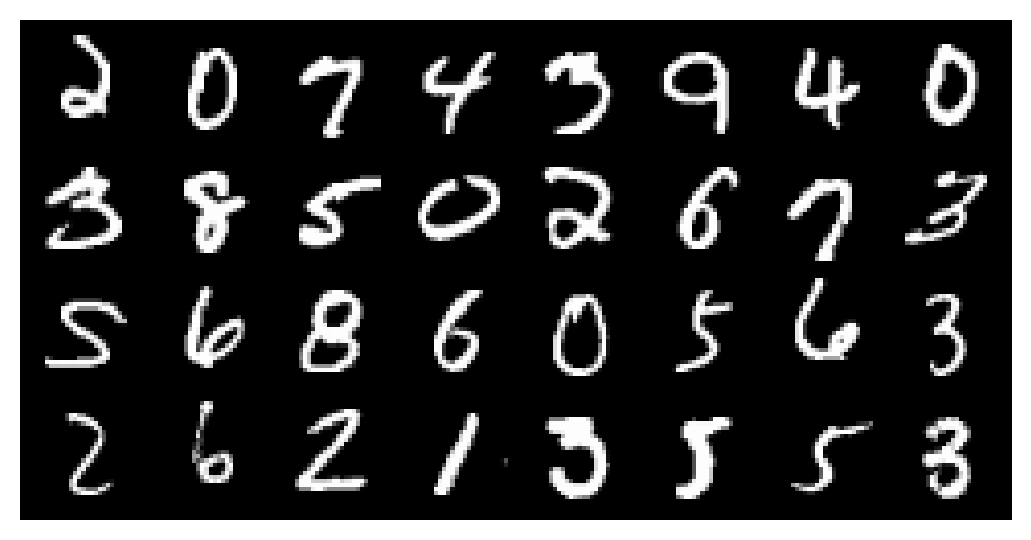

Reconstructed MNIST Images:


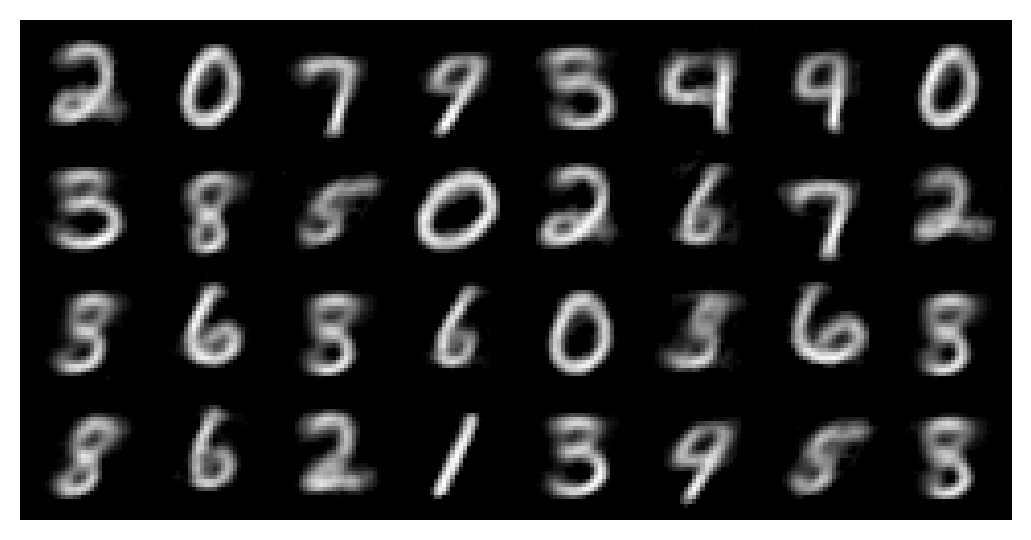

Original SVHN Images:


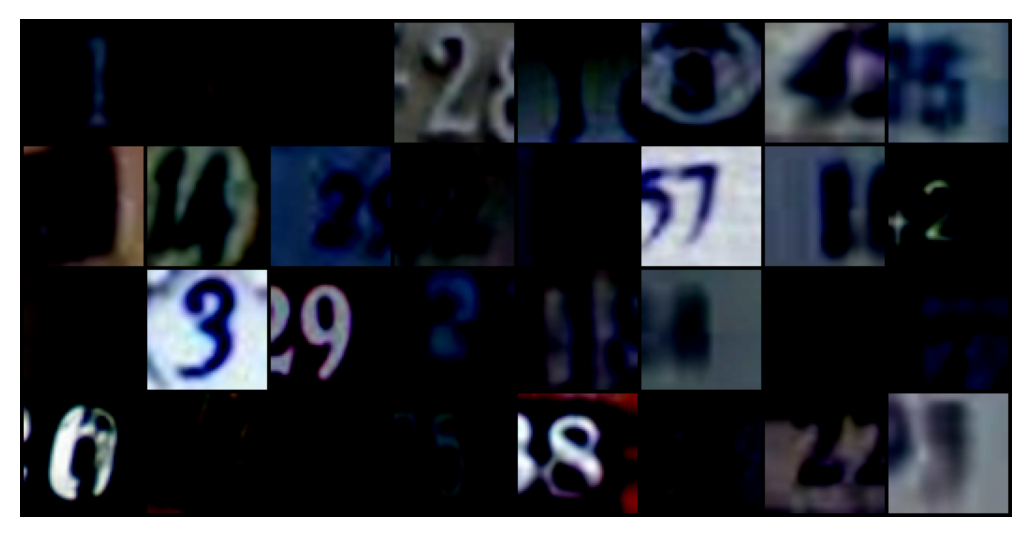

Reconstructed SVHN Images:


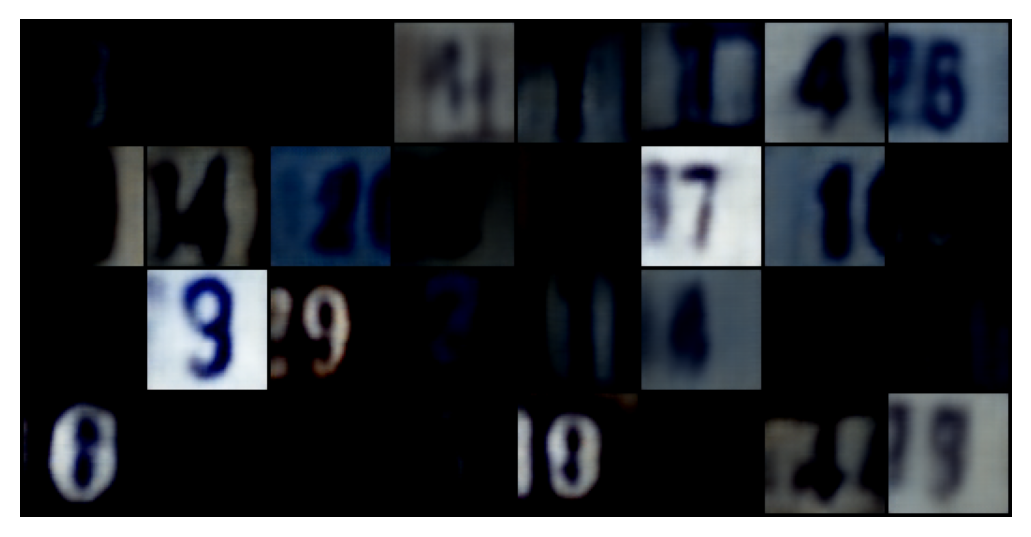

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Function to visualize images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Set the model to evaluation mode
multiview_vae.eval()

def get_test_dataset(batch_size, dataset_directory='./data'):
    mnist_transformation = transforms.Compose([
        transforms.ToTensor(),
    ])

    svhn_transformation = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    # MNIST:
    test_dataset_mnist = torchvision.datasets.MNIST(dataset_directory, train=False, download=True, transform=mnist_transformation)
    mnist_testloader = torch.utils.data.DataLoader(test_dataset_mnist, batch_size=batch_size, shuffle=True)

    # SVHN:
    test_dataset_svhn = torchvision.datasets.SVHN(dataset_directory, split='test', download=True, transform=svhn_transformation)
    svhn_testloader = torch.utils.data.DataLoader(test_dataset_svhn, batch_size=batch_size, shuffle=True)

    return mnist_testloader, svhn_testloader

mnist_testloader, svhn_testloader = get_test_dataset(32)

# Get a batch of test data
mnist_data, _ = next(iter(mnist_testloader))
svhn_data, _ = next(iter(svhn_testloader))

# Transfer data to device if using GPU
mnist_data = mnist_data.to(device)
svhn_data = svhn_data.to(device)

# Calculate loss to obtain reconstructed images
mnist_reconstructed, svhn_reconstructed, _, _ = multiview_vae.forward(mnist_data, svhn_data)

# Display original and reconstructed MNIST images
print("Original MNIST Images:")
imshow(torchvision.utils.make_grid(mnist_data.cpu()))

print("Reconstructed MNIST Images:")
imshow(torchvision.utils.make_grid(mnist_reconstructed.cpu()))

# Display original and reconstructed SVHN images
print("Original SVHN Images:")
imshow(torchvision.utils.make_grid(svhn_data.cpu()))

print("Reconstructed SVHN Images:")
imshow(torchvision.utils.make_grid(svhn_reconstructed.cpu()))


## TSNE Embedding

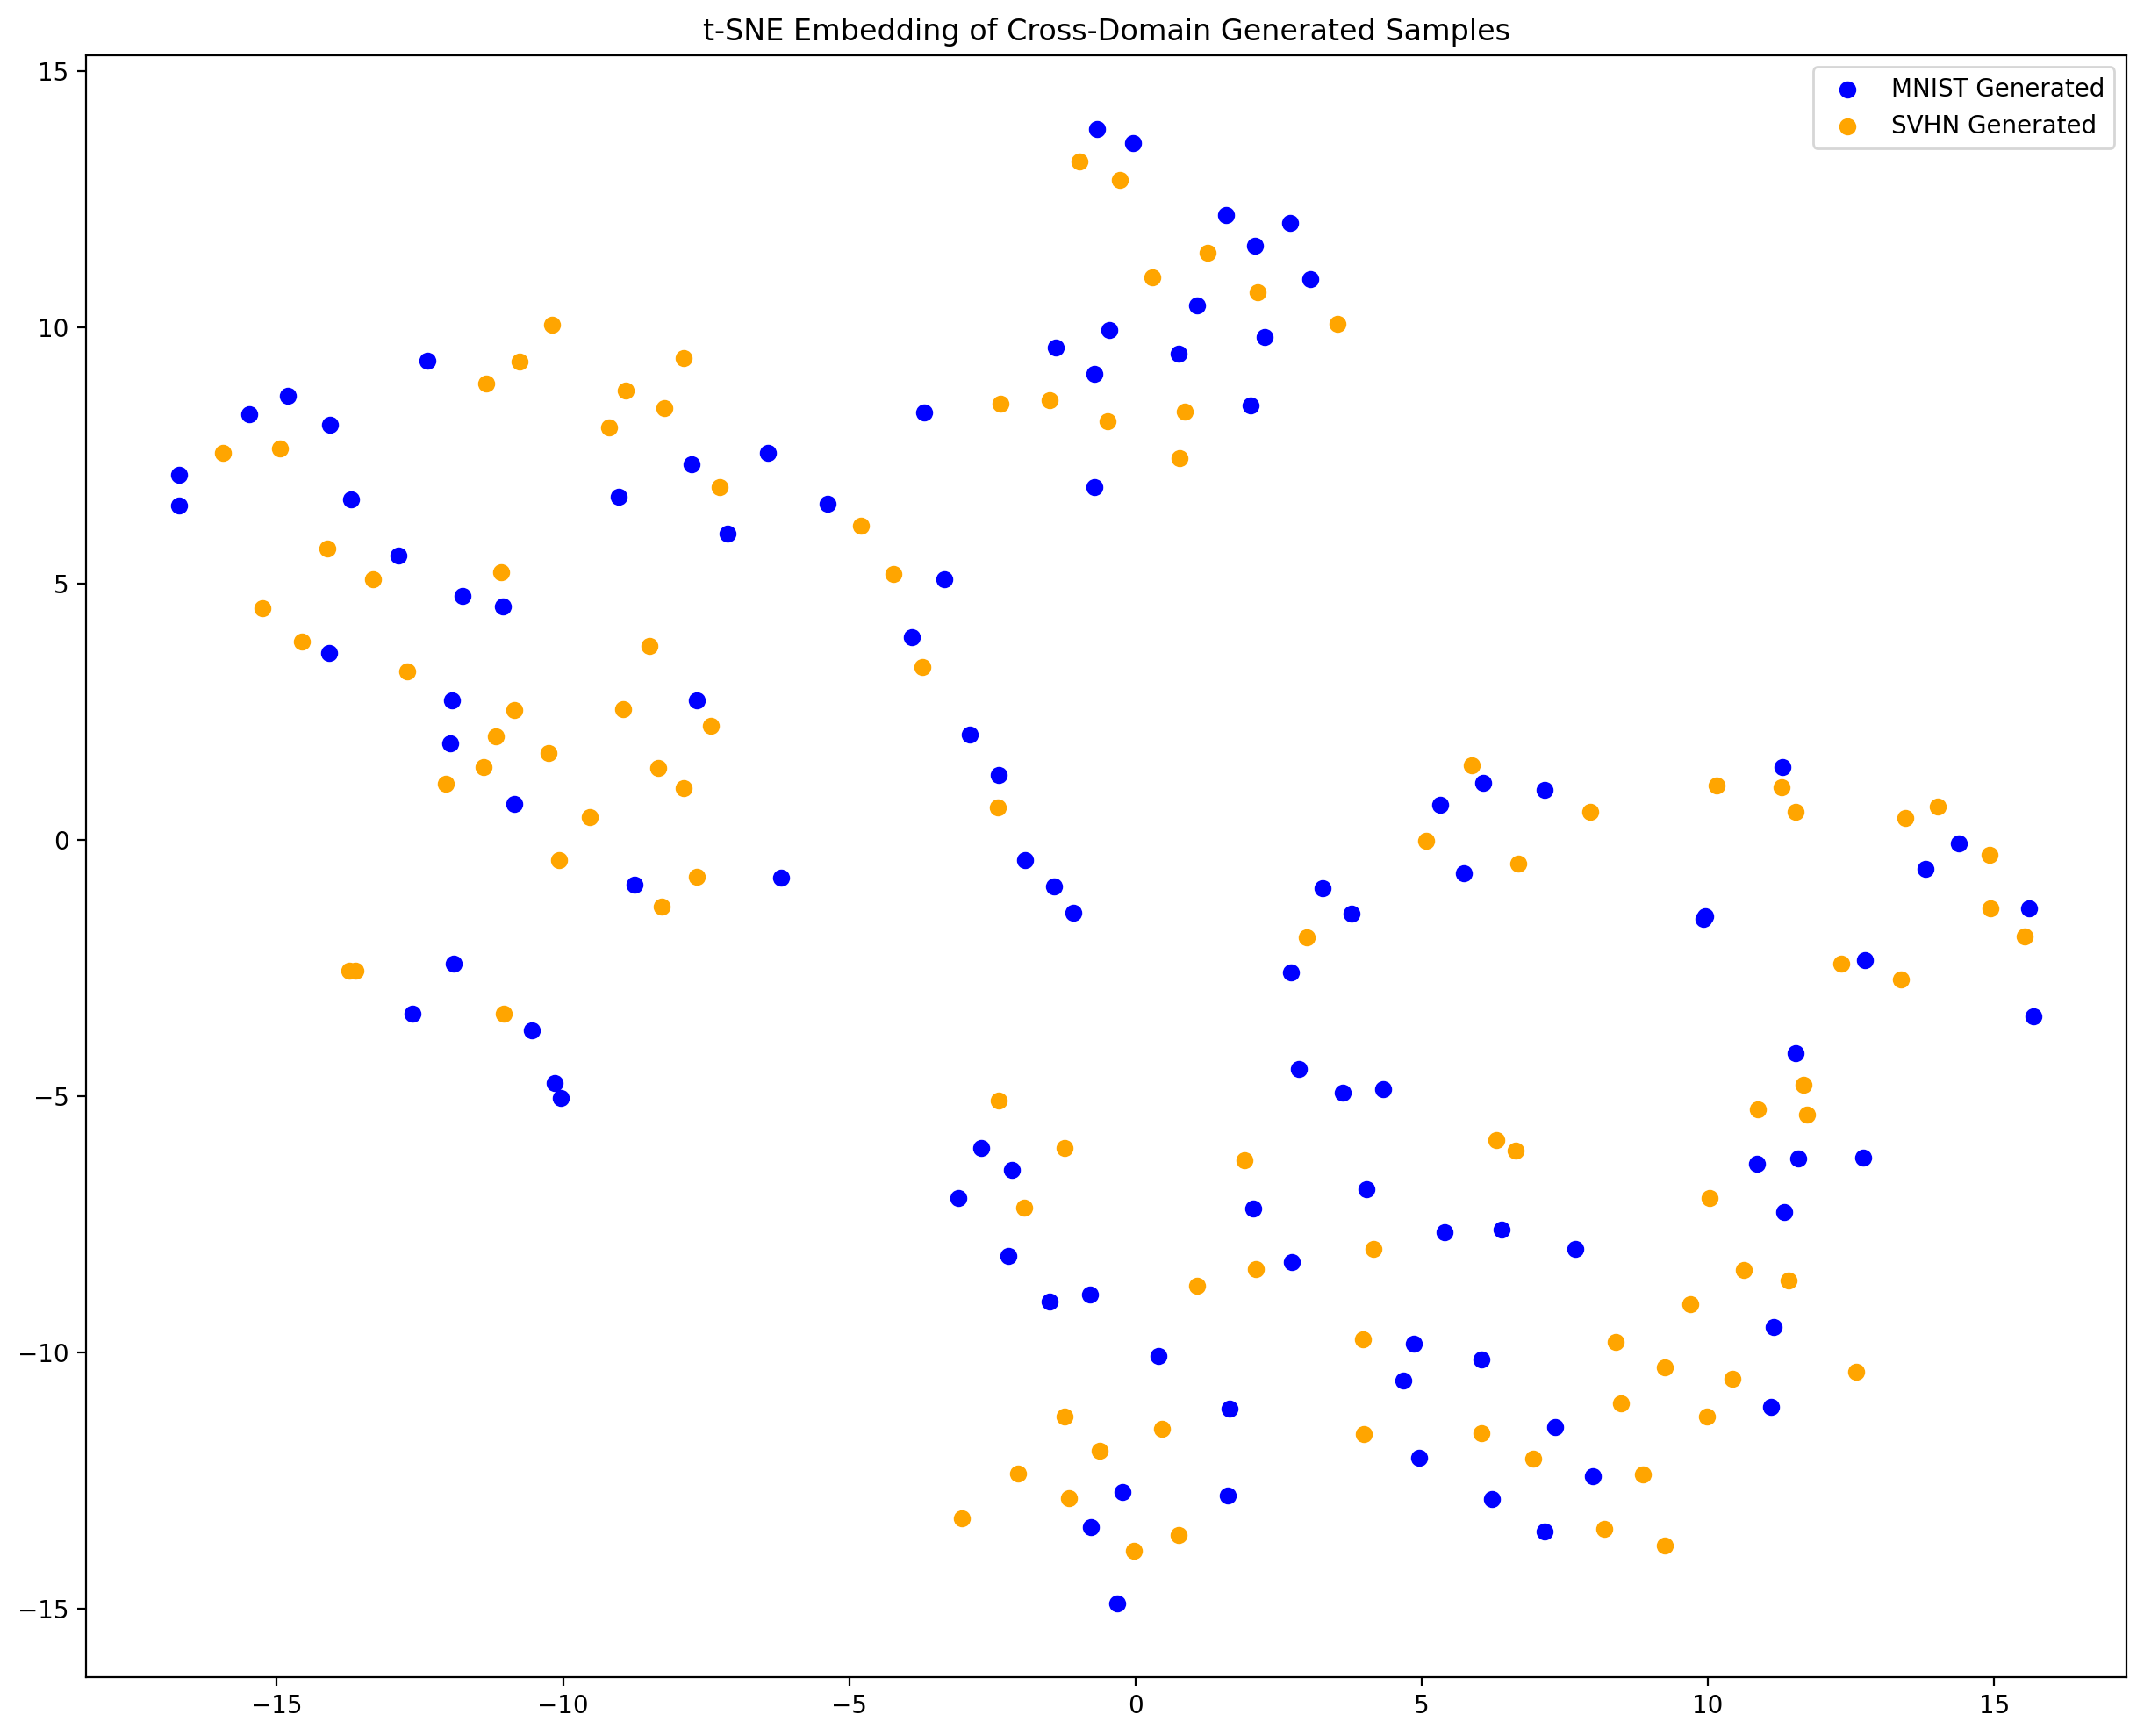

In [ ]:
import torch
import torchvision
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Set the model to evaluation mode
multiview_vae.eval()

# Generate cross-domain samples
num_samples = 100

# Generate SVHN samples from MNIST
mnist_samples, _ = multiview_vae.sample(num_samples)

# Generate MNIST samples from SVHN
svhn_samples, _ = multiview_vae.sample(num_samples)

# Combine generated samples
all_samples = torch.cat([mnist_samples, svhn_samples], dim=0)

# Apply t-SNE to reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30, early_exaggeration=12, n_jobs=-1)
tsne_results = tsne.fit_transform(all_samples.view(all_samples.size(0), -1))

# Plot t-SNE embedding with images
plt.figure(figsize=(15, 12))

# Plot MNIST samples
plt.scatter(tsne_results[:num_samples, 0], tsne_results[:num_samples, 1], color='blue', label='MNIST Generated')

# Plot SVHN samples
plt.scatter(tsne_results[num_samples:, 0], tsne_results[num_samples:, 1], color='orange', label='SVHN Generated')

plt.title('t-SNE Embedding of Cross-Domain Generated Samples')
plt.legend()
plt.show()


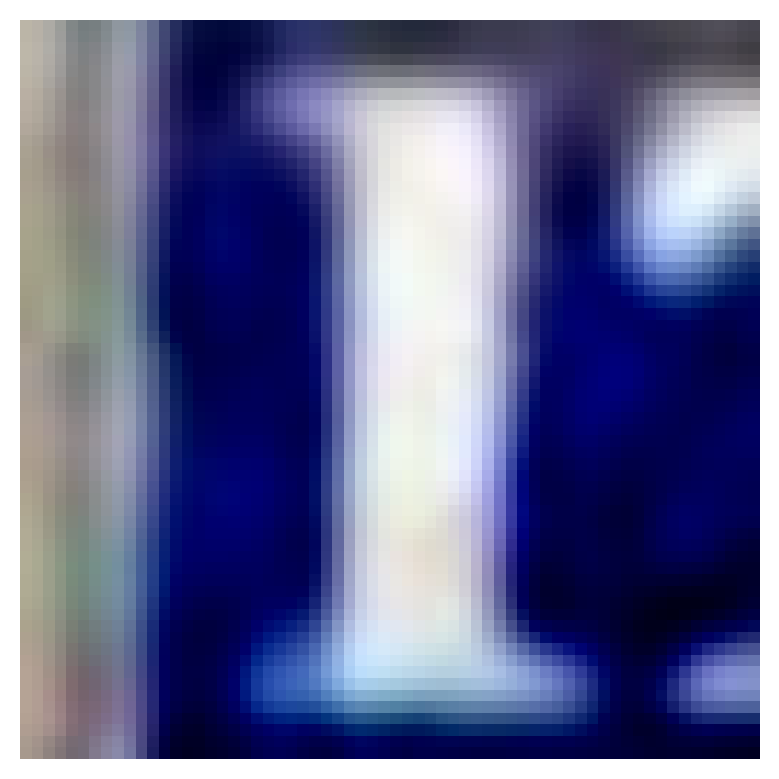

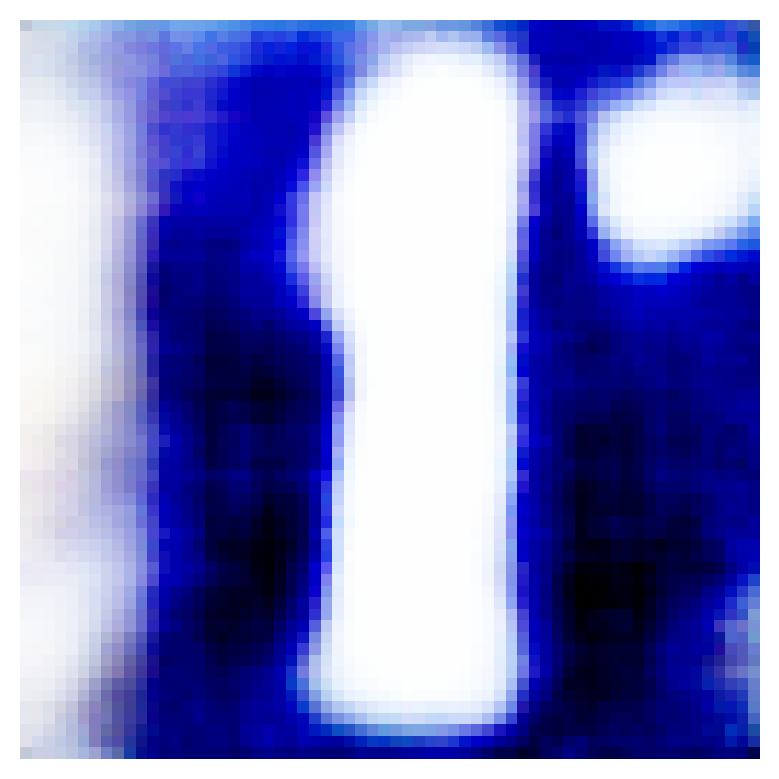

In [ ]:
z_batch, _, _ = multiview_vae.svhm_enc.encode_and_sample(x=i.to(multiview_vae.device), flag_sample=False)
x_reconstructed = multiview_vae.svhm_dec.decode(z_batch).detach()


imshow(i[0, :, :, :].to('cpu'))
imshow(x_reconstructed[0, :, :, :].to('cpu'))



In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def rescale(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

def plot_latent_space_with_images(images,latent,xmin=-150,xmax=150,ymin=-150,ymax=150):

    f, ax = plt.subplots(1,1,figsize=(8, 8))
    # ax is a figure handle
    ax.clear()
    for i in range(len(images)):
        im = OffsetImage(rescale(images[i,:,:,:]))
        ab = AnnotationBbox(im, latent[i,:],frameon=False)
        ax.add_artist(ab)
    #We set the limits according to the maximum and minimum values found for the latent projections
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_title('Latent space Z with Images')

In [ ]:
from sklearn.manifold import TSNE

# Apply TSNE over z_batch

latent_tsne = TSNE(n_components=2).fit_transform(z_batch.to('cpu').detach().numpy())

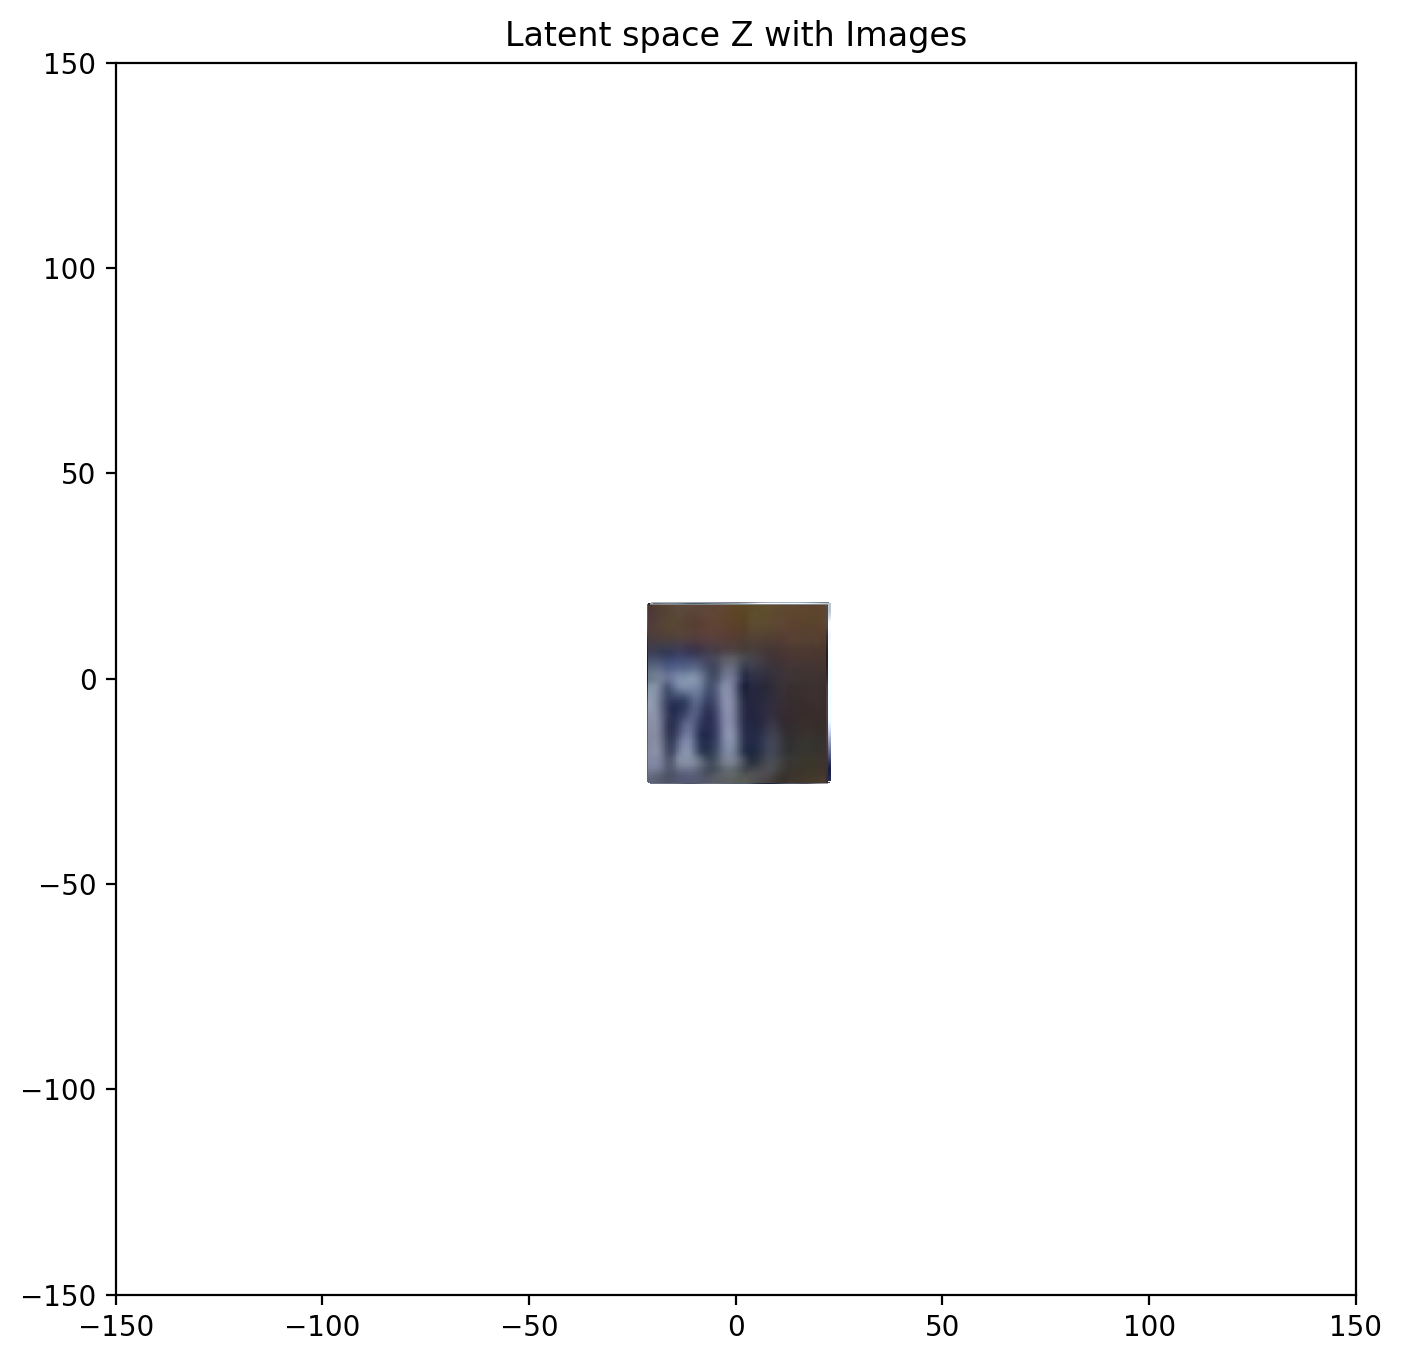

In [ ]:
plot_latent_space_with_images(i, latent_tsne)